In [1]:
!unzip drive/MyDrive/nlp_bootcamp/hse-2nd-step-in-nlp-bootcamp.zip

Archive:  drive/MyDrive/nlp_bootcamp/hse-2nd-step-in-nlp-bootcamp.zip
  inflating: sample_submission.csv   
  inflating: vacancies_test.csv      
  inflating: vacancies_train.csv     


In [2]:
!cp drive/MyDrive/nlp_bootcamp/vacancies_train_cleaned.csv .

# Импорт библиотек

In [3]:
import os
import string
import re

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
import torch
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.tokenize import sent_tokenize

from sklearn.feature_extraction.text import TfidfVectorizer

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [5]:
df_train = pd.read_csv('vacancies_train_cleaned.csv')
df_train.head()

,name,experience,schedule,employment,description,key_skills,salary,clean_description
0,Водитель-экспедитор,От 3 до 6 лет,Полный день,Полная занятость,"Водитель-экспедитор категории В,С (а\м ГАЗЕЛЬ ...",[],42500.0,водительэкспедитор категории вс ам газель тент...
1,Кладовщик-комплектовщик/оператор 1С,От 1 года до 3 лет,Полный день,Полная занятость,Обязанности: Списывание материалов в произво...,"['знание пк', 'работа в 1С', 'Работа в команде...",50000.0,обязанности списывание материалов производство...
2,"Продавец магазина ""Магнит"" (Кировский р-он, В....",Нет опыта,Сменный график,Полная занятость,"В крупнейшую Федеральную сеть магазинов ""Магни...",[],31500.0,крупнейшую федеральную сеть магазинов магнит т...
3,Администратор магазина (ТЦ Spar),От 1 года до 3 лет,Полный день,Полная занятость,Крупная федеральная сеть магазинов мужской и ж...,[],36700.0,крупная федеральная сеть магазинов мужской жен...
4,Мойщик посуды (кулинария),Нет опыта,Сменный график,Полная занятость,Обязанности: Уборка производственных площадей...,"['Пользователь ПК', 'Грамотная речь', 'Работа ...",37000.0,обязанности уборка производственных площадей к...


# EDA

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16629 entries, 0 to 16628
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   name         16629 non-null  object 
 1   experience   16629 non-null  object 
 2   schedule     16629 non-null  object 
 3   employment   16629 non-null  object 
 4   description  16629 non-null  object 
 5   key_skills   16629 non-null  object 
 6   salary       16629 non-null  float64
dtypes: float64(1), object(6)
memory usage: 909.5+ KB


От 3 до 6 лет: 2236
От 1 года до 3 лет: 6881
Нет опыта: 7278
Более 6 лет: 234


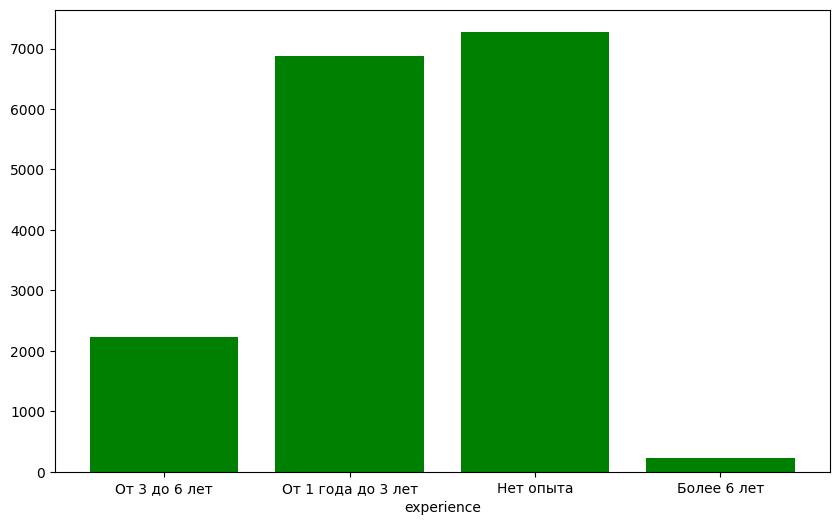

In [ ]:
x = [x for x in range(len(df_train['experience'].unique()))]
y = []
for exp in df_train['experience'].unique():
  print(f"{exp}: {df_train[df_train['experience'] == exp]['experience'].count()}")
  y.append(df_train[df_train['experience'] == exp]['experience'].count())

plt.figure(figsize=(10,6))
plt.xlabel('experience')
plt.bar(x, y, color='green', tick_label=df_train['experience'].unique())
plt.show()

Полный день: 11424
Сменный график: 2719
Гибкий график: 687
Вахтовый метод: 1160
Удаленная работа: 639


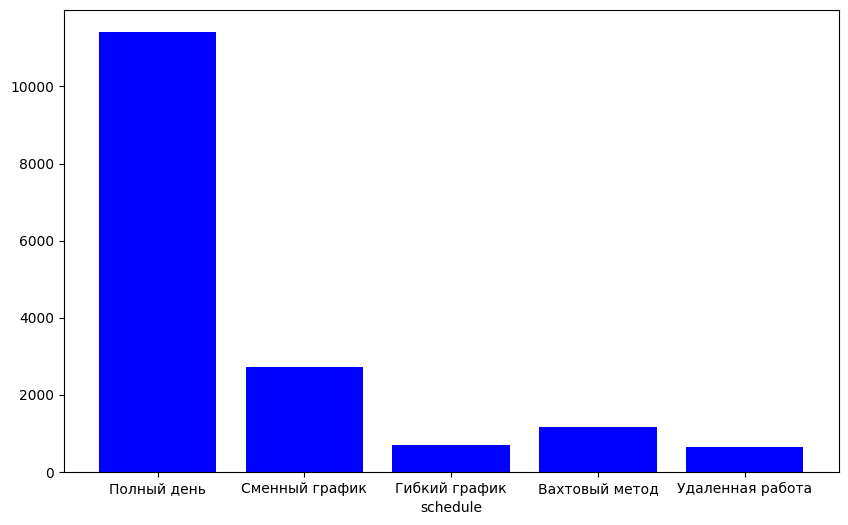

In [ ]:
data_plt = df_train['schedule'].unique()
x = [x for x in range(len(data_plt))]
y = []
for data in data_plt:
  print(f"{data}: {df_train[df_train['schedule'] == data]['schedule'].count()}")
  y.append(df_train[df_train['schedule'] == data]['schedule'].count())

plt.figure(figsize=(10,6))
plt.xlabel('schedule')
plt.bar(x, y, color='blue', tick_label=data_plt)
plt.show()

Полная занятость: 15723
Частичная занятость: 803
Проектная работа: 67
Стажировка: 36


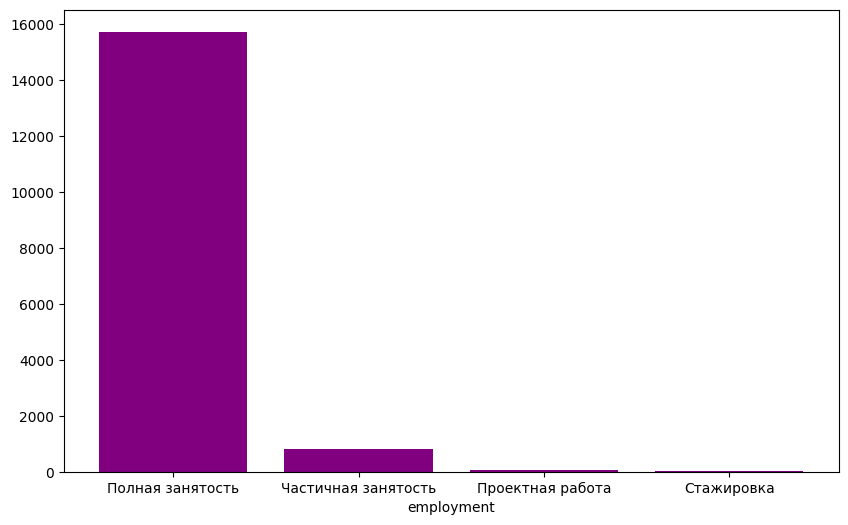

In [ ]:
data_plt = df_train['employment'].unique()
x = [x for x in range(len(data_plt))]
y = []
for data in data_plt:
  print(f"{data}: {df_train[df_train['employment'] == data]['employment'].count()}")
  y.append(df_train[df_train['employment'] == data]['employment'].count())

plt.figure(figsize=(10,6))
plt.xlabel('employment')
plt.bar(x, y, color='purple', tick_label=data_plt)
plt.show()

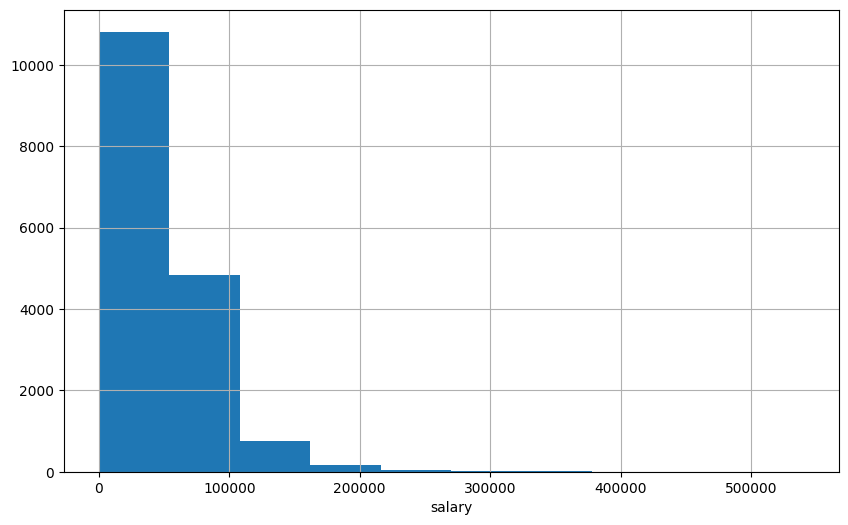

In [ ]:
plt.figure(figsize=(10,6))
plt.xlabel('salary')
df_train['salary'].hist()
plt.show()

In [ ]:
print(f"Количество уникальных названий вакансий - {len(df_train['name'].unique())}")

Количество уникальных названий вакансий - 9915


# Очистка текста

In [6]:
def clean_text(text):
    table = text.maketrans(dict.fromkeys(string.punctuation))
    
    words = word_tokenize(text.lower().strip().translate(table))
    words = [word for word in words if word not in stopwords.words('russian')]
    lemmed = [WordNetLemmatizer().lemmatize(word) for word in words]    
    return " ".join(lemmed)

In [ ]:
df_train['text'] = df_train['name'] + ' ' + df_train['description'] + ' ' + df_train['key_skills']

In [ ]:
df_train['clean_text'] = df_train['text'].apply(clean_text)
df_train['clean_text']

0        водительэкспедитор водительэкспедитор категори...
1        кладовщиккомплектовщикоператор 1с обязанности ...
2        продавец магазина магнит кировский рон уса кру...
3        администратор магазина тц spar крупная федерал...
4        мойщик посуды кулинария обязанности уборка про...
                               ...                        
16624    полицейский специального полка полиции обязанн...
16625    врач стоматологортопед г новосибирск обязаннос...
16626    фармацевт условия официальное оформление тк рф...
16627    геодезист автодороги обязанности своевременное...
16628    специалистэксперт отдела правового обеспечения...
Name: clean_text, Length: 16629, dtype: object

In [ ]:
df_train.to_csv('vacancies_train_textcleaned.csv', index=False)

# Модель

In [7]:
from sklearn.model_selection import train_test_split
X = df_train.drop(['name', 'salary', 'key_skills', 'description'], axis=1)
y = df_train['salary']

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.3)

## Обучение catboost

In [8]:
!pip install catboost -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 9.1 MB/s eta 0:00:00


In [9]:
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import StratifiedKFold

In [11]:
cat_features = ['experience','schedule','employment']
text_features = ['clean_description']

train_pool = Pool(
    Xtrain, 
    ytrain, 
    cat_features=cat_features, 
    text_features=text_features, 
    feature_names=list(Xtrain)
)
valid_pool = Pool(
    Xtest, 
    ytest,
    cat_features=cat_features, 
    text_features=text_features, 
    feature_names=list(Xtrain)
)

catboost_params = {
    'iterations': 10000,
    'learning_rate': 0.01,
    'eval_metric': 'R2',
    'task_type': 'GPU',
    'early_stopping_rounds': 100,
    'use_best_model': True,
    'verbose': 1000
}

model = CatBoostRegressor(**catboost_params)
model.fit(train_pool, eval_set=valid_pool)

Default metric period is 5 because R2 is/are not implemented for GPU
Metric R2 is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.0034905	test: 0.0029433	best: 0.0029433 (0)	total: 27.5ms	remaining: 4m 35s
1000:	learn: 0.4654082	test: 0.3561019	best: 0.3561019 (1000)	total: 42.3s	remaining: 6m 20s
2000:	learn: 0.5444688	test: 0.3831066	best: 0.3831066 (2000)	total: 1m 2s	remaining: 4m 10s
3000:	learn: 0.5934298	test: 0.3961486	best: 0.3961486 (3000)	total: 1m 20s	remaining: 3m 7s
4000:	learn: 0.6271625	test: 0.4039026	best: 0.4039026 (4000)	total: 1m 37s	remaining: 2m 26s
5000:	learn: 0.6546836	test: 0.4090758	best: 0.4090787 (4998)	total: 1m 58s	remaining: 1m 58s
6000:	learn: 0.6771234	test: 0.4128023	best: 0.4128023 (6000)	total: 2m 16s	remaining: 1m 31s
7000:	learn: 0.6949699	test: 0.4156304	best: 0.4156304 (7000)	total: 2m 33s	remaining: 1m 5s
8000:	learn: 0.7104591	test: 0.4172871	best: 0.4173169 (7985)	total: 2m 53s	remaining: 43.4s
bestTest = 0.417772933
bestIteration = 8342
Shrink model to first 8343 iterations.


In [12]:
import pickle

pickle.dump(model, open('cat_model.pkl', 'wb'))

## Обучение xgboost

In [13]:
!pip install xgboost -q

from xgboost import XGBRegressor

#### label encoder

In [53]:
from sklearn.preprocessing import LabelEncoder

enc_le = LabelEncoder()

experience_df = pd.DataFrame(enc_le.fit_transform(df_train[['experience']]), columns=['experience'])
schedule_df = pd.DataFrame(enc_le.fit_transform(df_train[['schedule']]), columns=['schedule'])
employment_df = pd.DataFrame(enc_le.fit_transform(df_train[['employment']]), columns=['employment'])

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


#### onehot encoder

In [14]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(handle_unknown='ignore')
# passing bridge-types-cat column (label encoded values of bridge_types)
experience_df = pd.DataFrame(enc.fit_transform(X[['experience']]).toarray(), columns=X['experience'].unique())
schedule_df = pd.DataFrame(enc.fit_transform(X[['schedule']]).toarray(), columns=X['schedule'].unique())
employment_df = pd.DataFrame(enc.fit_transform(X[['employment']]).toarray(), columns=X['employment'].unique())

In [15]:
train_upd = pd.concat([experience_df, schedule_df, employment_df], axis=1)

#### word2vec

In [16]:
!pip install gensim==4.2 -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.0/24.0 MB 17.1 MB/s eta 0:00:00


In [18]:
from gensim.models import Word2Vec
VEC_SIZE = 300
%time w2v_model = Word2Vec(sentences=df_train['clean_description'], vector_size=VEC_SIZE, sg=1, hs=1, window=9, min_count=10)

CPU times: user 9min 34s, sys: 829 ms, total: 9min 35s
Wall time: 6min 5s


In [19]:
def make_w2v_features(texts):
    w2v_features = []
    words_count = 0
    for element in texts:
        comment = np.zeros(VEC_SIZE)
        element_tokenized = nltk.word_tokenize(element)
        for word in element_tokenized:
            words_count += 1
            if word in w2v_model.wv.key_to_index.keys():
                word_vector = w2v_model.wv[word]
                comment = comment + word_vector
        
        if words_count == 0:
            words_count = 1
        w2v_features.append(comment/words_count)
        words_count = 0
                
    return w2v_features

In [20]:
w2v_train = pd.DataFrame(make_w2v_features(df_train['clean_description']))

In [21]:
w2v_train[train_upd.columns] = train_upd[train_upd.columns].reset_index(drop=True)

In [22]:
w2v_train.shape

(16629, 313)

In [23]:
Xtrain, Xtest, ytrain, ytest = train_test_split(w2v_train, y, test_size=0.3)

In [24]:
xgb=XGBRegressor(learning_rate = 0.01,
                       n_estimators = 200)
xgb.fit(Xtrain, ytrain)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=200, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [29]:
pickle.dump(xgb, open('xgb_model.pkl', 'wb'))

In [25]:
from sklearn.metrics import r2_score, make_scorer
from sklearn.model_selection import cross_val_score

scorer = make_scorer(r2_score, greater_is_better=True)
result =  cross_val_score(xgb, w2v_train, y, cv=3, scoring=scorer)
print(result.mean())

0.1671510691929966


## Обучение LightGBM

In [26]:
from lightgbm import LGBMRegressor

lgbm = LGBMRegressor(boosting_type='gbdt', n_estimators=200)
lgbm.fit(Xtrain, ytrain)

LGBMRegressor(n_estimators=200)

In [27]:
pickle.dump(lgbm, open('lgbm_model.pkl', 'wb'))

In [28]:
from sklearn.metrics import r2_score, make_scorer
from sklearn.model_selection import cross_val_score

scorer = make_scorer(r2_score, greater_is_better=True)
result =  cross_val_score(lgbm, w2v_train, y, cv=3, scoring=scorer)
print(result.mean())

0.20713416544629495


# Инференс модели

In [30]:
test = pd.read_csv('vacancies_test.csv')
test.head()

,id,name,experience,schedule,employment,description,key_skills
0,0,Главный бухгалтер,Более 6 лет,Полный день,Полная занятость,Обязанности:Осуществление организации бухгалте...,"['1С: Предприятие 8', '1C: Предприятие', 'Рабо..."
1,1,Ассистент врача-стоматолога,От 1 года до 3 лет,Сменный график,Полная занятость,"Обязанности: Ассистировать врачу стоматологу,...","['Пользователь ПК', 'Работа в команде', 'Умени..."
2,2,Менеджер по продажам,От 1 года до 3 лет,Полный день,Полная занятость,Если ты: хочешь построить карьеру в банковс...,[]
3,3,Менеджер,От 1 года до 3 лет,Полный день,Полная занятость,Динамично развивающаяся на протяжении 17 лет...,"['Оценка потребностей клиентов', 'оформление д..."
4,4,Администратор хостела,Нет опыта,Сменный график,Полная занятость,ВОЗМОЖНА РАБОТА С ПРОЖИВАНИЕМ Обязанности: Пр...,[]


In [31]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5543 entries, 0 to 5542
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           5543 non-null   int64 
 1   name         5543 non-null   object
 2   experience   5543 non-null   object
 3   schedule     5543 non-null   object
 4   employment   5543 non-null   object
 5   description  5543 non-null   object
 6   key_skills   5543 non-null   object
dtypes: int64(1), object(6)
memory usage: 303.3+ KB


In [32]:
test['text'] = test['name'] + test['description'] + test['key_skills']

In [33]:
test['clean_text'] = test['text'].apply(clean_text)

In [34]:
cleaned_test = test.drop(['id','name', 'key_skills', 'description', 'text'], axis=1)

## w2v

In [35]:
w2v_test = pd.DataFrame(make_w2v_features(cleaned_test['clean_text']))

In [36]:
experience_test = pd.DataFrame(enc.fit_transform(test[['experience']]).toarray(), columns=X['experience'].unique())
schedule_test = pd.DataFrame(enc.fit_transform(test[['schedule']]).toarray(), columns=X['schedule'].unique())
employment_test = pd.DataFrame(enc.fit_transform(test[['employment']]).toarray(), columns=X['employment'].unique())

In [37]:
test_upd = pd.concat([experience_test, schedule_test, employment_test], axis=1)
test_upd.head()

,От 3 до 6 лет,От 1 года до 3 лет,Нет опыта,Более 6 лет,Полный день,Сменный график,Гибкий график,Вахтовый метод,Удаленная работа,Полная занятость,Частичная занятость,Проектная работа,Стажировка
0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0


In [38]:
w2v_test[test_upd.columns] = test_upd[test_upd.columns].reset_index(drop=True)
w2v_test.head()

,0,1,2,3,4,5,6,7,8,9,...,Более 6 лет,Полный день,Сменный график,Гибкий график,Вахтовый метод,Удаленная работа,Полная занятость,Частичная занятость,Проектная работа,Стажировка
0,-0.003738,0.010985,0.004887,0.002376,0.003956,-0.004477,0.001485,0.002532,-0.002982,-0.004552,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
2,0.000017,0.001176,0.001055,0.000924,0.000740,-0.000727,0.000224,0.000272,-0.000086,-0.000595,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.000026,0.000151,0.001626,0.001532,0.000201,0.001609,0.000011,0.000221,-0.000149,0.002145,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.000017,0.002865,0.001971,0.002387,-0.000125,-0.001294,-0.000012,-0.001504,-0.000433,0.002490,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0


In [39]:
xgb_pred = xgb.predict(w2v_test)

In [40]:
lgb_pred = lgbm.predict(w2v_test)

In [43]:
cat_preds = model.predict(cleaned_test.rename({'clean_text': 'clean_description'}, axis=1))

In [44]:
preds = (xgb_pred + lgb_pred + cat_preds)/3

In [45]:
subm = test.drop(['name', 'key_skills', 'description','experience','schedule','employment', 'text', 'clean_text'], axis=1)

In [46]:
subm['salary'] = preds

In [47]:
subm.head()

,id,salary
0,0,70136.560173
1,1,46641.536609
2,2,57560.405571
3,3,55215.678761
4,4,34018.842147


In [48]:
subm.to_csv('vacancies_subm.csv', index=False)